# Data Analysis Example in R
### Adapted by Carrie Brown from "The Bigmemory Project: Introductory Example" by Michael Kane and John Emerson

Using USA Commerical Flight Data from 1997 to 2008, this analysis covers data loading, integration and basic visualization to attempt to discern possible causes of flight delays.

**If you wish to run this notebook interactively:** you will be need to run the `get_data.submit` job (using the command `sbatch get_data.submit`) to download the necessary datafiles.  It is also recommended to change the data load step to use the truncated data set to improve run times.

In [3]:
# load required libraries
library(dplyr)
library(ggplot2)
library(maps)
library(randomForest)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.

Attaching package: ‘randomForest’

The following object is masked from ‘package:ggplot2’:

    margin

The following object is masked from ‘package:dplyr’:

    combine



In [4]:
# Load airline.csv data - to run this interactively, change the file to './data/airline_truc.csv'
flights <- read.csv("./data/airline_subsample.csv",
  sep=",", 
  header=TRUE,
  stringsAsFactors=FALSE)

# Explore the data
head(flights)
str(flights)

Year,Month,TailNum,ArrDelay,Origin
1987,10,NA,NA,JFK
1987,11,NA,2,MCI
1987,11,NA,0,SAN
1987,12,NA,31,ORD
1987,10,NA,12,LAX
1987,12,NA,0,ATL


'data.frame':	2200000 obs. of  5 variables:
 $ Year    : int  1987 1987 1987 1987 1987 1987 1987 1987 1987 1987 ...
 $ Month   : int  10 11 11 12 10 12 11 12 10 10 ...
 $ TailNum : chr  NA NA NA NA ...
 $ ArrDelay: int  NA 2 0 31 12 0 -12 -2 0 -5 ...
 $ Origin  : chr  "JFK" "MCI" "SAN" "ORD" ...


In [5]:
# Remove flights with missing data
flights <- na.omit(flights)

dim(flights)

[1] 1366017       5

In [6]:
# Function to estimate birthmonth of aircraft by finding the month and year of first flight
birthmonth <- function(y){
  minYear <- min(y[,'Year'], na.rm=TRUE)
  these <- which(y[,'Year']==minYear)
  minMonth <- min(y[these, 'Month'], na.rm=TRUE)
  return(12 * minYear + minMonth - 1)
}

# Create vectors for each aircraft (aircrafts) and store their birthmonth (acStart)
aircrafts <- unique(flights[,'TailNum'])
aircrafts <- aircrafts[!is.na(aircrafts)]

acStart <- rep(0, length(aircrafts))

for (i in aircrafts) {
  acStart[i] <- birthmonth(flights[flights$TailNum==i,])
}

tail(acStart)

N304DQ N348AT N816NW N805NW N822SK N516AS 
 24106  24102  24096  24101  24107  24107

In [7]:
# Calculate flight age using the birthmonth
age <- data.frame(names(acStart), acStart, stringsAsFactors = FALSE)
colnames(age) <- c("TailNum", "acStart")
flights <- left_join(flights, age, by="TailNum")
flights <- mutate(flights, Age = (flights$Year * 12) + flights$Month - flights$acStart)

head(flights)

Year,Month,TailNum,ArrDelay,Origin,acStart,Age
1995,3,N240AU,5,BWI,23940,3
1995,12,N605AU,108,TPA,23940,12
1995,10,N178AW,1,PHX,23940,10
1995,11,N966VJ,-7,PIT,23940,11
1995,1,N903DE,-4,PNS,23940,1
1995,2,N997Z,7,AUS,23941,1


In [8]:
# Generate linear model for response: ArrDelay and predictor: Age 
lm <- lm(ArrDelay ~ Age, data=flights)
summary(lm)


Call:
lm(formula = ArrDelay ~ Age, data = flights)

Residuals:
    Min      1Q  Median      3Q     Max 
-182.32  -15.37   -7.42    3.64 1437.54 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 7.279e+00  2.802e-02   259.8   <2e-16 ***
Age         2.113e-03  1.189e-05   177.7   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 32.68 on 1379269 degrees of freedom
Multiple R-squared:  0.02238,	Adjusted R-squared:  0.02238 
F-statistic: 3.158e+04 on 1 and 1379269 DF,  p-value: < 2.2e-16


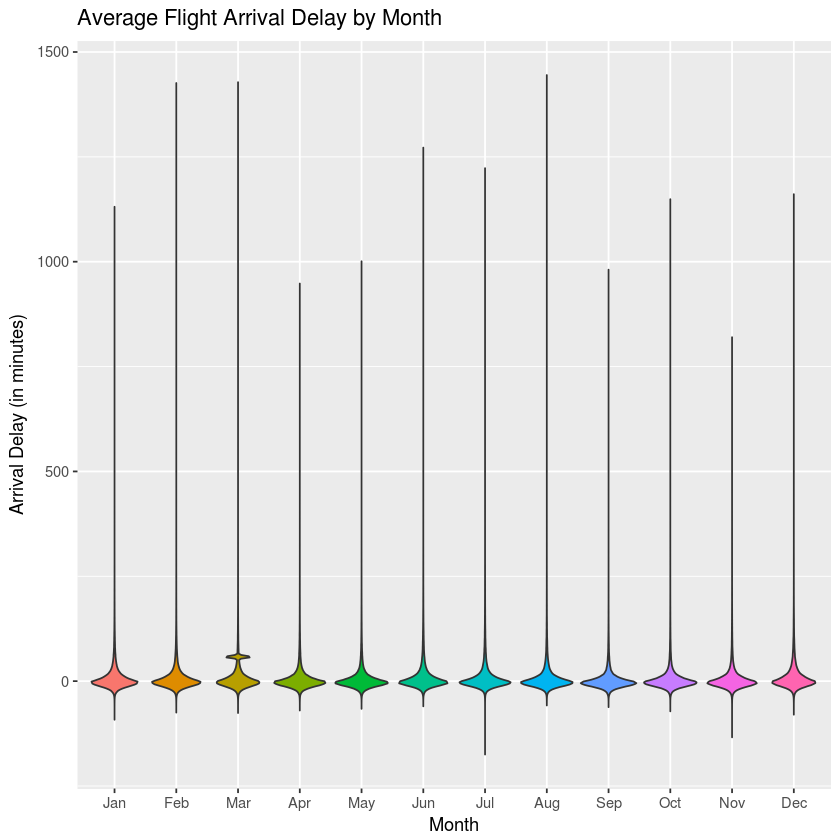

In [9]:
# Convert Months from number to factor
flights$Month <- factor(flights$Month)
levels(flights$Month) <- month.abb

# Select a subset of fields needed to graph arrival delays by month
subset_month <- select(flights, Month, ArrDelay)

# Create violin graph showing arrival delays by month
ggplot(subset_month, aes(Month,ArrDelay, fill=factor(Month))) + 
       geom_violin(aes(group=Month)) + 
       theme(legend.position="none") +
       labs(y = "Arrival Delay (in minutes)") + 
       labs(title = "Average Flight Arrival Delay by Month")

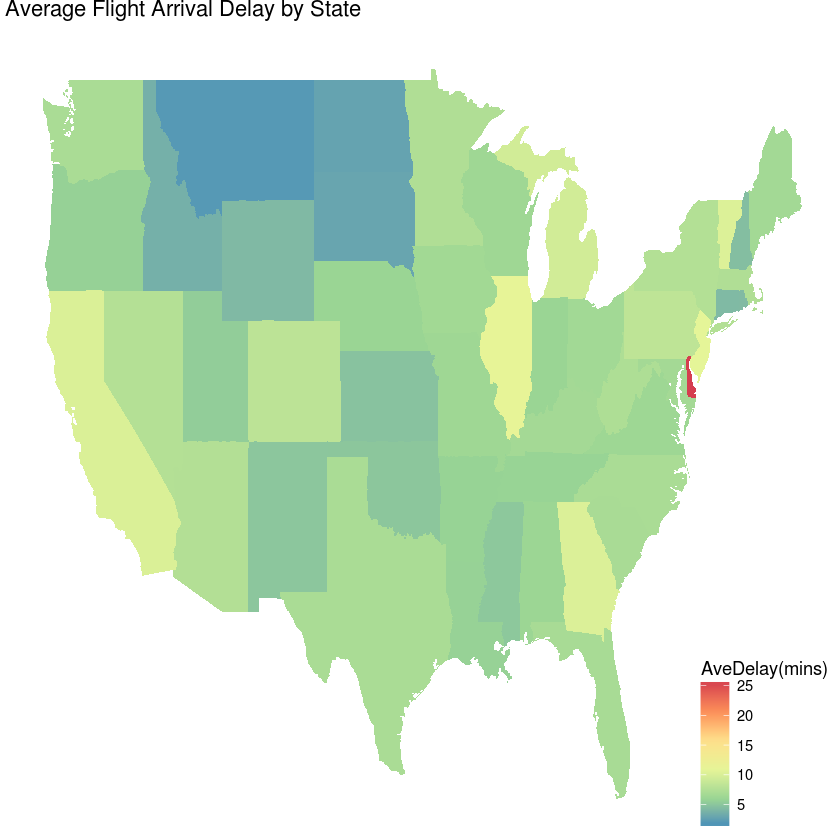

In [10]:
# Load state list for airport codes and join departure state to flights dataframe
airport_codes <- read.csv("./data/airport_codes.csv",
                        col.names=c("OriginState", "Origin"),
                        stringsAsFactors = FALSE)
flights <- left_join(flights, airport_codes, by="Origin")

# Create subset of data containing origin state and arrival delay
subset_state <- select(flights, OriginState, ArrDelay)
subset_state <- subset_state[!is.na(subset_state$ArrDelay),]
subset_state <- group_by(subset_state, OriginState)
subset_summary <- summarise(subset_state, AveDelay=mean(ArrDelay))

# Create graphic of US States colored by average delay time
map = map_data("state")

ggplot(subset_summary, aes(fill=AveDelay)) + 
  geom_map(aes(map_id=OriginState), map=map) +
  scale_fill_distiller(name = "AveDelay(mins)", palette = "Spectral", direction=-1) +
  expand_limits(x=map$long, y=map$lat) +
  theme_void() +
  labs(title = "Average Flight Arrival Delay by State") +
  theme(legend.justification = c(1, 0), legend.position = c(1, 0))

In [11]:
# Bin based on arrival times
flights$ArrCategory <- cut(flights$ArrDelay, c(-120,-15,15,120,400), c("Early", "On-Time", "Late", "Very Late"))

# Remove any remaining NA's
flights_subset <- select(flights, Month, Year, OriginState, Age, ArrCategory)
flights_subset <- na.omit(flights_subset)
flights_subset$OriginState <- as.factor(flights_subset$OriginState)

# Divide data into training and testing sets
flights.train <- rownames(sample_frac(flights_subset, .8))
flights.test <- rownames(flights)[!(rownames(flights_subset) %in% flights.train)]

length(flights.train)
length(flights.test)

[1] 1070222

[1] 275881

In [12]:
# Create random forest to predict ArrCategory
forest <- randomForest(ArrCategory ~ OriginState + Month + Year, flights_subset[flights.train,], ntree=10)
forest


Call:
 randomForest(formula = ArrCategory ~ OriginState + Month + Year,      data = flights_subset[flights.train, ], ntree = 10) 
               Type of random forest: classification
                     Number of trees: 10
No. of variables tried at each split: 1

        OOB estimate of  error rate: 31.16%
Confusion matrix:
          Early On-Time Late Very Late class.error
Early        54  108157  263         0 0.999502185
On-Time     395  728141 1229         0 0.002225374
Late        130  204159 1137         0 0.994465160
Very Late    11   15748   42         0 1.000000000

In [13]:
forest$importance

,MeanDecreaseGini
OriginState,5906.318
Month,4530.451
Year,6233.670


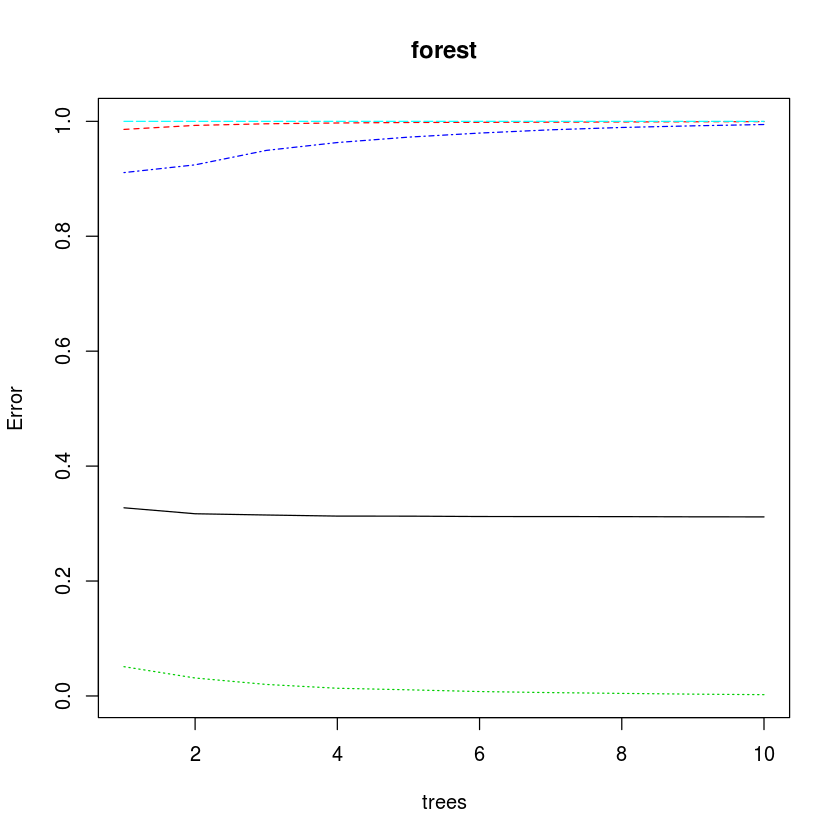

In [14]:
plot(forest)